# カーネル法を用いたサポートベクタマシン（SVM）

svmは入力空間の超平面のような簡単なモデルではなく、より複雑なモデルを可能にするために線形サポートベクタマシンを拡張したもの。

### 線形モデルと非線形特徴量


低次元における線形モデルは制約が強い=>直線や超平面が柔軟性を制限するため．

なので線形モデルを柔軟にする方法として，特徴量の追加が用いられる．    
例）入力特徴量の交差作業（積）や多項式項を加える。

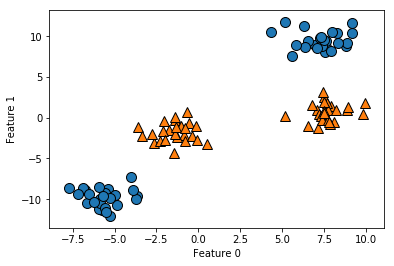

In [4]:
import mglearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

線形分離できなデータの例

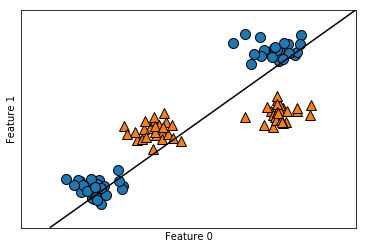

In [2]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

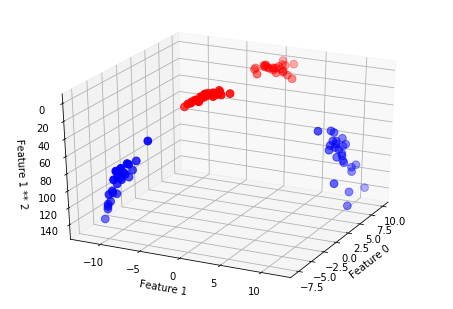

In [3]:
import numpy as np
X_new = np.hstack([X, X[:, 1:]**2]) #feature1 feature2 に加えて feature ** 2の特徴量が増える。

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)

mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', cmap=mglearn.cm2, s=60)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")
plt.show()

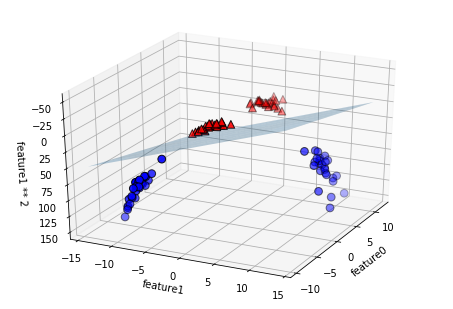

In [7]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")
plt.show()

次元を増やしたことにより、線形分離可能になった。

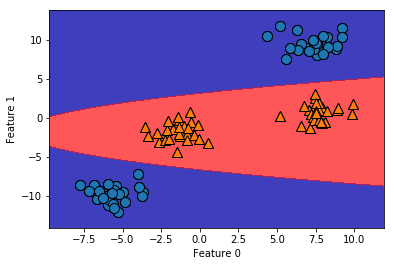

In [9]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

もとの特徴量の関数としてみると、線形SVMモデルは線形ではなくなってる。楕円の様になってる。

### カーネルトリック

`カーネルトリック`は拡張された特徴表現上でのデータポイント間の距離を，実際にデータポイントの拡張を計算せずに，直接計算する方法である．

- SVMで扱われている高次元空間へのマップ方法
    - 元の特徴量の特定の次数までの位全ての多項式を計算する多項式カーネル(ex: x_1 ** 2 +* x_2 ** 5)
    - 放射基底関数(RBF)カーネル，別名ガウシアンカーネル
        - 全ての次数の全ての多項式を考えるが，次数が高くなると，その特徴量の重要性を低くする

## SVMを理解する

SVMは個々のデータポイントが２つのクラスの決定境界を表現するのにどのくらい重要か学習する．その際二つの境界に位置するごく一部の訓練データポイントだけが決定境界を決定する．これらのデータポイントを`サポートベクタ`と呼ぶ．

新しいデータポインタに対して予測を行う際に，サポートベクタとデータポイントとの距離が測定される．クラス分類はこのサポートベクタとの距離と，訓練過程で学習された個々のサポートベクタの重要性によって決定される．

データポイント間の距離は次のようなガウシアンカーネルで測られる．

$$ k_{rbf}(x_1, x_2) = \exp(-\gamma||x_1-x_2||^2) $$

$x_1,x_2$はデータポイントである．$||x_1-x_2||$はユークリッド距離，$\gamma$（ガンマ）はガウシアンカーネルの幅を制御するパラメータである．

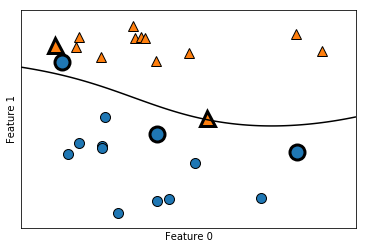

In [5]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

sv = svm.support_vectors_

sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

### SVMパラメータの調整

gammaはガウシアンカーネルの幅を調整する。Cは線形モデルでいうところの正則化パラメータ。

gammaが小さいと決定境界はゆっくりとしか変化せず，モデルの複雑さは小さくなる．gammaが大きいとよりモデルは複雑になる．
Cが小さいと制限されたモデルに対応し，個々のデータポイントの与える影響は限定される．

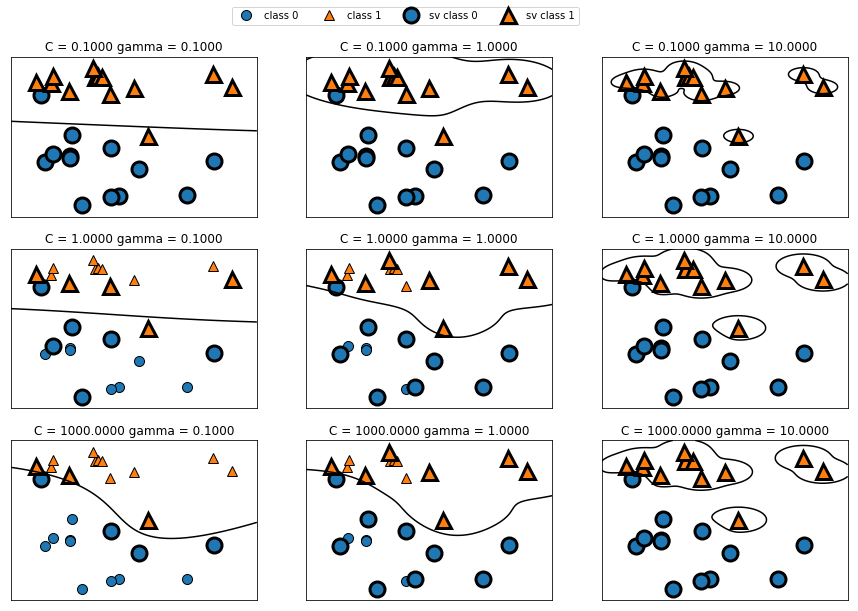

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2))
plt.show()

左から右へガウシアンカーネルの幅gammaを0.1から10に変化している。gammaが大きくなるとモデルが複雑になる。    
上から下に向けて正則化項Cを0.1から1000に変化させている。Cを大きくするとここのデータに影響される。

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.cross_validation import train_test_split

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


学習データに過剰適合してる。svmはパラメータ設定とデータスケールに敏感。    
対数で特徴量をプロットするとスケールが違うことがわかる。

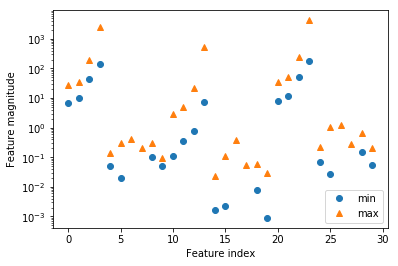

In [7]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")
plt.show()

## SVMの為のデータ前処理

特徴量毎にサイズが違うと，カーネル法を用いたSVMでは破壊的な影響をもたらす．この問題を解決する方法の一つが，全ての特徴量が大体同じスケールになるように，それぞれスケール変換する方法=>0~1の間にスケール変換する．

In [28]:
min_on_training = X_train.min(axis=0)
range_on_training = (X_train - min_on_training).max(axis=0)

X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Maximum for each feature
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [29]:
X_test_scaled = (X_test - min_on_training) / range_on_training

In [32]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


In [34]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


### 利点，欠点，パラメータ

- 利点

大体うまく行く

- 欠点
    - サンプルの個数が大きくなると実行時間，メモリ使用量でキツい
    - データの前処理とパラメータ調整が大切


- パラメータ
    - C(正則化パラメータ)
    - カーネルの選択とカーネル固有のパラメータ

データにわずかな特徴量しかない場合にも複雑な決定境界を生成できる。低次元でも高次元でもうまく機能するが、サンプルの個数が大きくなるとうまく機能しない。
１０万データになると実行時やメモリ使用量の面で難しい。予測された理由を非専門家へ説明するのが難しい。    
画像データなどはスケールが近いのでsvmを試して見る価値はある。